# Reproducible exploratory analysis: Mitigating multiplicity when mining data

Identifying meaningful patterns and relationships among data, including big data, is a fundamental component of neuroscience research; however, multiplicity—the practice of conducting multiple simultaneous comparisons, can result in spurious and misleading conclusions. In this unit, learners will understand how multiplicity occurs, its impacts, and strategies to address it.

<div class="alert alert-block alert-danger">
<b>Alert:</b> If you're running this on <b>Google Colab</b>, then uncomment and run the next two cells.
</div>

In [ ]:
# !git clone https://github.com/Mark-Kramer/METER-Units.git

In [ ]:
# import sys
# sys.path.insert(0,'/content/METER-Units')

## 1 - Rat brains, position, and profit: an introduction to exploratory analysis

In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
# Load custom functions
from exploratory_functions import *

<div class="alert alert-block alert-info">

*Introduction*:

- Background studies suggest relationships between neural activity and phenomena in the world.
- For example, action potentials (or "spikes") occurring in a rodent's brain indicate:
    - the rodent's location in the world ([citation](https://www.nature.com/articles/514153a), Nobel Prize)
    - stock prices of companies on the NYSE ([citation](https://improbable.com/airchives/paperair/volume12/v12i4/rats-12-4.pdf), Annals of Improbable Research).
- In this unit, you’ll explore a large data set to search for these types of relationships.
- You’ll be confronted with a **challenge**: how will you decide among many possible relationships which are meaningful?
</div>

<div class="alert alert-block alert-success">

**Q:** When exploring data, the number of relationships between the things you observe increases quickly with the number of observed items. To get a sense for this, consider the results in ([citation](https://improbable.com/airchives/paperair/volume12/v12i4/rats-12-4.pdf), Annals of Improbable Research), How many relationships were tested?

**A:** Activity from 94 neurons was compared with activity from 4195 stocks. The total number of comparisons considered is 94*4195 = 381,745.

*Interpretation*: That number can get very big with modern big data observations!

</div>

<div class="alert alert-block alert-success">

**Q:** Consider `N` neurons and `M` signals. How many possible combinations of relationships exist between the neurons and signals?

**A:**  N*M

*Interpretation*: That number can get very big with modern big data observations!

</div>

## [2 - Visualization, the first step in exploration]

Motivated by [previous](https://www.nature.com/articles/514153a) [studies](https://improbable.com/airchives/paperair/volume12/v12i4/rats-12-4.pdf), you receive data from a collaborator interested in understanding the relationship between neural spiking in the rodent brain, rodent position, and stock prices on the NYSE. The data consist of the following information:

* `spikes`  - the action potentials (or "spikes") generated by 200 neurons,

* `signals` - the rodent position (one of the signals) and the price of 99 stocks.

Both the `spikes` and `signals` are recorded simultaneously, every 10 ms for 0.5 s, resulting in a total of 500 time points.

**Wrinkle:** For the `signals`, our collaborator isn't sure which of the 100 signals correpsonds to the rodent position. This happens sometimes. We that 1 of the 100 signals is the rodent position, but not which one. That's ok for now, in our exploratory analysis.

In [2]:
spikes, signals, t = load_data()

We're interested in understanding the relationship (if any) between `spikes` and `signals`.

Let's start by investigating the structure of the data.

In [3]:
print(spikes.shape)
print(signals.shape)

(500, 200)
(500, 100)


Both `spikes` and `signals` consist of 500 time points (the number of rows). We collect data from 200 spikes and 100 signals (the number of columns).

Let's plot the data from one neuron in `spikes`:

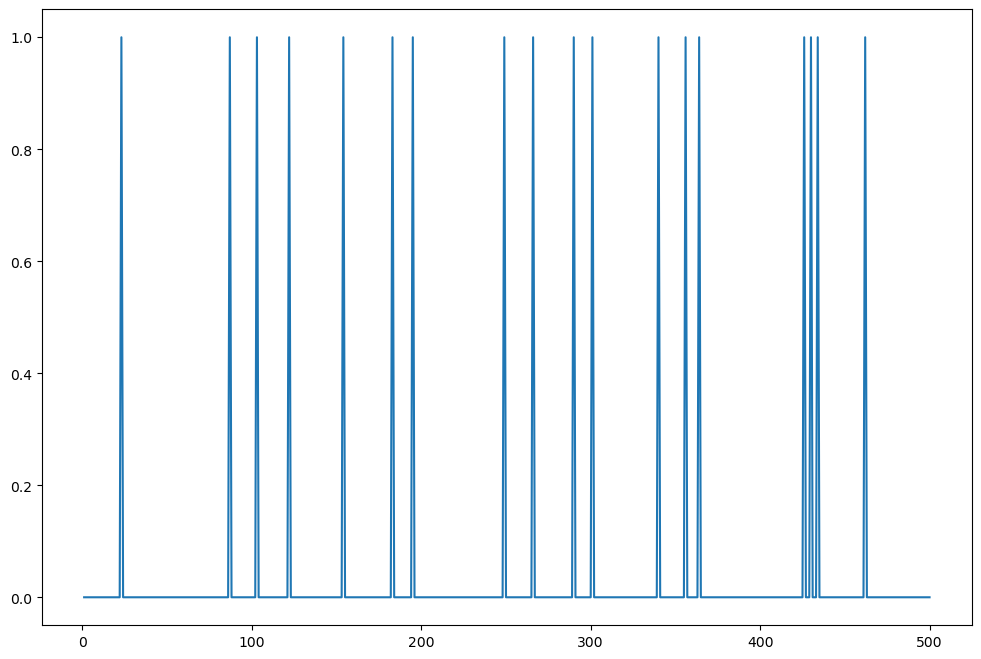

In [4]:
# Plot the spiking from an example neuron.
plt.figure(figsize=(12, 8))
plt.plot(t, spikes[:,0]);

<div class="alert alert-block alert-success">

**Q:** How do these data represent "spikes"?

**A:** In this signal, the value 1 represnets a spike occurs at time 't'. The value 0 indicates that no spike occurs at time 't'.

</div>

Let's also plot the data from one signal in `signals`:

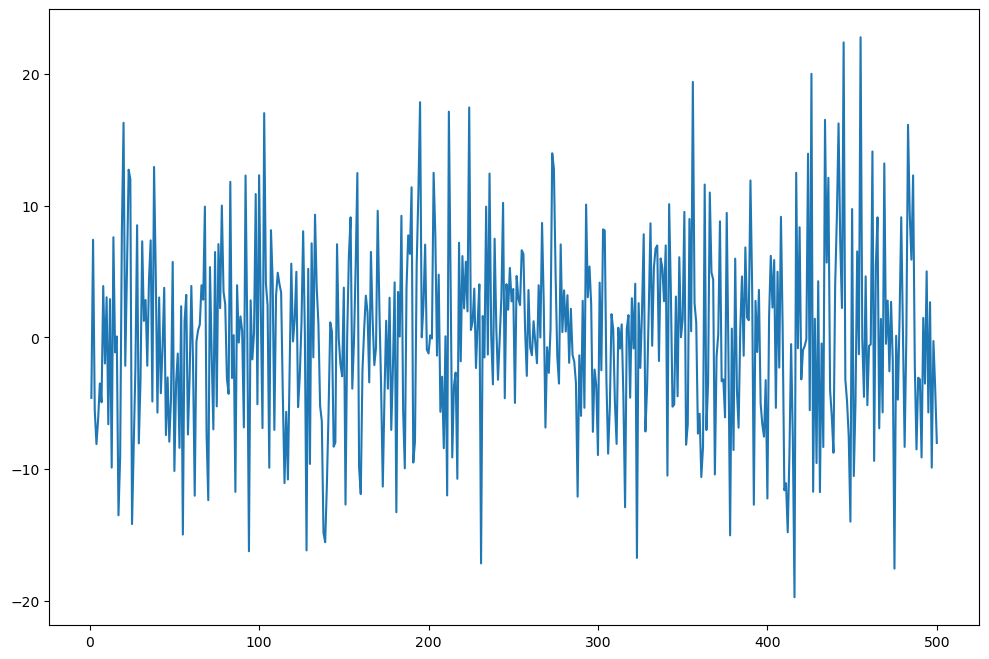

In [5]:
# Plot the spiking from an example neuron.
plt.figure(figsize=(12, 8))
plt.plot(t, signals[:,0]);

<div class="alert alert-block alert-success">

**Q:** What features do you notice in the signal?

**A:** It's "wiggly" and maybe there are rhythmic oscillations, but it's hard to tell. It's "noisy".

</div>

<div class="alert alert-block alert-success">

**Q:** Compare the plots of example spiking and an example signal. Are they related?

**A:** It's very difficult to tell what relationship - if any - exists between the signals.

*Interpretation*: Visual inspection is not especially useful in this example.


</div>

## 3- Profit! Rat brains for high-frequency trading in the NYSE

Let's now investigate the pairwise associations between the spiking of 200 neurons in the rat brain, the rat position, and 99 stock prices.

<div class="alert alert-block alert-success">

**Q:** We have 200 neurons and 100 signals. How many possible combinations of relationships exist between the neurons and signals?

**A:**  200*100 = 20,000

*Interpretation*: That's a large number! I wonder if we'll find something interesting in there ...

</div>

In [6]:
n1 = signals.shape[1]
n2 = spikes.shape[1]
p = np.zeros((n1, n2))

for i in tqdm(range(n1)):       # tqdm shows the progress bar
    for j in range(n2):
        # GLM fitting with a Poisson family
        X = signals[:, i]       # Predictor variable
        y = spikes[:, j]        # Response variable
        X = sm.add_constant(X)  # Adding a constant column for the intercept
        glm_model = sm.GLM(y, X, family=sm.families.Poisson())
        glm_results = glm_model.fit()
        p[i, j] = glm_results.pvalues[1]  # Storing the p-value of the predictor

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


For each neuron-signal pair, we estimate the association with an associated p-value. Let's visualize those p-values.

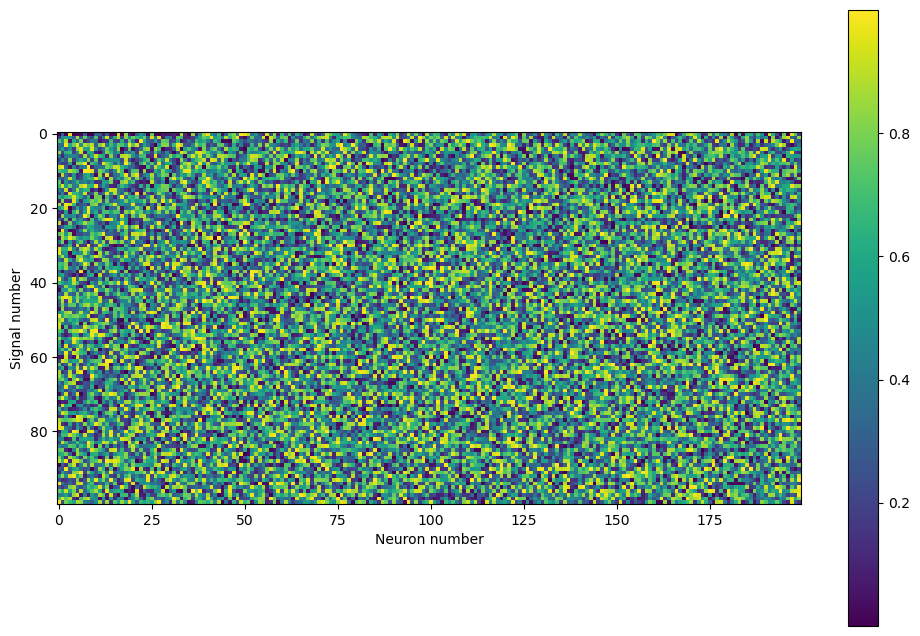

In [7]:
plt.figure(figsize=(12, 8))
plt.imshow(p); plt.colorbar();
plt.xlabel('Neuron number'); plt.ylabel('Signal number');

<div class="alert alert-block alert-success">

**Q:** What do you observe? Can you find the meaningful relationships between neurons and signals, if any? 

**A:** We're looking for small values (the darkest blue) in the image. It's very difficult to see the meaningful relationships. The image is noisy.

</div>

To isolate meaningful relationships, let's find all associations in which p<0.05, the standard threshold for signficance applied in practice.

In [8]:
np.sum(p < 0.05)

1043

<div class="alert alert-block alert-success">

**Q:** Interpert this result. What do you conclude about the data?

**A:** Of the 20,000 possible associations between spikes and signals, we detect 1043 associations with p<0.05.

*Interpretation*: Rat brains are associated with stock prices! Let's develop a new strategy for profitable high-frequency stock trading using rat brain neuron spiking.


</div>

<div class="alert alert-block alert-danger">
<b>Alert: Wait, this doesn't make sense!</b>

</p>

- How can the spike timing in a rat brain relate to stock market prices?

- We've identified all associations with p<0.05 ... Is that the right choice?
</div>

<div class="alert alert-block alert-info">

*Moment of tension*:

- Hook the learner - "something isn't right and I want to know why."

</div>

## 4- Not so fast … finding meaningful relationships after you’ve tested everything.


In Mini 3, we assessed associations between 200 neurons and 100 signals.

This exploration led to many (20,000) statistical tests.

We now need to **correct for multiplicity**.

When conducting multiple hypothesis tests, increased error rates occur because each test has a chance of incorrectly rejecting the null hypothesis (a false positive). This error, typically called the Type I error, is the probability of a single test falsely claiming a statistically significant effect.

As more tests are performed, the cumulative probability of committing at least one Type I error across all these tests increases, leading to an overall higher error rate for the set of tests than for any individual test. This phenomenon is often referred to as the "multiple comparisons problem" or "multiplicity."

Our we must adjust our statistical significance threshold to account for increased error rates due to conducting multiple hypothesis tests on the same dataset.

<div class="alert alert-block alert-success">

**Q:** In our initial analysis, we chose a Type I error rate ($\alpha$) of 0.05. So, each test has a probability of 0.05 of falsely claiming a statistically significant effect.

We performed 20,000 total tests. How many false statistically significant effects do we expect?


**A:** 20,000 * 0.05 = 1000

*Interpretation*: Because we conducted so many tests (20,000), and selected all associations with p<0.05, we expect 1000 false positives. In Unit 3, we found 1043 associations with p<0.05. We conclude that most of these associatiosn are false positives!

</div>

To correct for multiplicity, let's apply a popular procedure: **the Bonferroni correction**.

The Bonferroni correction reduces the Type I error rate by dividing the desired overall significance level ($\alpha$) by the number of tests performed.

<div class="alert alert-block alert-success">

**Q:** Compute the Bonferroni correction using our desired overall significance level ($\alpha=0.05$) and the number of tests performed.


**A:** 0.05 / 20000 = 0.0000025

*Interpretation*: Using the Bonferroni correction, we now declare associations as significant if p < 0.0000025.

</div>

Let's apply the Bonferroni correction to our matrix of p-values (`p`) and determine the number of significant associations, after correcting for multiplicity.

In [9]:
np.sum(p < 0.05/20000)

0

<div class="alert alert-block alert-success">

**Q:** Interpert this result. What do you conclude about the data?

**A:** Of the 20,000 possible associations between spikes and signals, we detect 0 associations with p<0.05 after applying the Bonferroni correction.

*Interpretation*: Rat brains not associated with stock prices or positions.

</div>

<div class="alert alert-block alert-danger">
<b>Alert: Wait, this doesn't make sense!</b>

</p>

- Much work (including Noble Prize work) has established a relationship between rat neuron spiking and rodent position.

- We've identified all associations with p<0.05 after Bonferroni correction ... Is that the right choice?

</div>

## 5- Rat brains either predict everything or nothing?


We've applied two strategies to confront multiplicity in exploratory analysis

- do nothing (Mini 3)
- Bonferroni correction (Mini 4)

The two strategies give completely different results. Either neurons in the rat brain spike with many associations to observed signals (Mini 3) or no associations (Mini 4). And, neither result makes sense. So, now what?

Many strategies exist to correct for multiplicity. There's no single "right" approach.

- Our first approach (do nothing) is too lenient - we allow two many false positives.
- Our second approach (Bonferroni correction) is too strict - we allow too few false positives.

Perhaps we can find an intermediate appraoch, that allows neither too many nor too few false positives ...

In what follows, you can explore alternatives to our choices above, and see how these choices impact your results.

Choose your own adventure!

- FDR (Mini 6)
- Split the data (Mini 7)



In [ ]:
N_modeled = 800;                                  # This is the a part!
number_of_repetitions = 1000
p_value = np.zeros(number_of_repetitions)
for k in np.arange(number_of_repetitions):
    ind = np.random.choice(np.size(x), N_modeled)  # There's something new here, and in the next line.
    lifespan_modeled = intercept + slope * x[ind] + np.random.normal(loc=0.0, scale=dispersion, size=[N_modeled,1])
    dat                = {"x": x[ind], "lifespan": lifespan_modeled}
    regression_results = ols("lifespan ~ 1 + x", data=dat).fit()
    p_value[k] = regression_results.pvalues[1]
Power = np.sum(p_value < 0.05)/number_of_repetitions
print('N=',N_modeled,'Power=',Power)

<div class="alert alert-block alert-danger">
<b>Alert:</b>
</p>

- Notice the use of `ind` and `x[ind]` in the code. Why do we need this here?
</div>

<div class="alert alert-block alert-success">

**Q:** Compare this code to the code in Mini 6. What has changed?

**A:** ... we include `N_modeled` as a new variable.

</div>

<div class="alert alert-block alert-success">

**Q:** At what value of `N_modeled` is the power just above 0.8?

- How does this compare to the results from your online calculator?
- How does this result compare to your resampling approach in Mini 6?

**A:**

</div>